In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read the consolidated number of employees
empl = pd.read_csv('data/toyota_number_of_employees.csv', usecols = [0, 2], index_col = 0)

empl.head()

,Consolidated number of employees
Year,
2000,210709
2001,215648
2002,246702
2003,264096
2004,264410


In [3]:
# From the production data we only need the year and the worldwide production numbers
prod = pd.read_csv('data/toyota_production_by_country.csv', usecols = [0, 32], index_col = 0)
empl_prod = empl.assign(worldwide_production = prod)

empl_prod.head()

,Consolidated number of employees,worldwide_production
Year,,
2000,210709,5180651
2001,215648,5134629
2002,246702,5640389
2003,264096,6078282
2004,264410,6723674


In [4]:
# Read total assets
assets = pd.read_csv('data/toyota_total_assets.csv', index_col = 0)
empl_prod_assets = empl_prod.assign(total_assets = assets)

empl_prod_assets.head()

,Consolidated number of employees,worldwide_production,total_assets
Year,,,
2000,210709,5180651,16469.054
2001,215648,5134629,17519.427
2002,246702,5640389,19305.730
2003,264096,6078282,20152.974
2004,264410,6723674,22040.228


In [5]:
# The production function will be estimated using the Cobb-Douglas production function
# The Cobb-Douglas production function is not linear, so it needs to be converted to linear form before fitting
# We convert it to linear form by taking the natural logarithm of it

empl_prod_assets['logQ'] = np.log(empl_prod_assets['worldwide_production'])
empl_prod_assets['logL'] = np.log(empl_prod_assets['Consolidated number of employees'])
empl_prod_assets['logK'] = np.log(empl_prod_assets['total_assets'])

empl_prod_assets.head()

,Consolidated number of employees,worldwide_production,total_assets,logQ,logL,logK
Year,,,,,,
2000,210709,5180651,16469.054,15.460441,12.258233,9.709238
2001,215648,5134629,17519.427,15.451518,12.281403,9.771066
2002,246702,5640389,19305.730,15.545464,12.415936,9.868157
2003,264096,6078282,20152.974,15.620233,12.484068,9.911107
2004,264410,6723674,22040.228,15.721145,12.485256,10.000625


In [6]:
import statsmodels.formula.api as smf

# Ordinary least squares for simple linear regression
model = smf.ols(formula = 'logQ ~ logL + logK', data = empl_prod_assets).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logQ   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     41.57
Date:                Sat, 22 Feb 2020   Prob (F-statistic):           2.84e-07
Time:                        23:45:40   Log-Likelihood:                 22.494
No. Observations:                  20   AIC:                            -38.99
Df Residuals:                      17   BIC:                            -36.00
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1955      3.084      2.657      0.017       1.688      14.703
logL           0.3199      0.376      0.851      0.406      -0.473       1.113
logK           0.3485      0.174      2.005      0.061      -0.018       0.715
==============================================================================
Omnibus:                        0.548   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.760   Jarque-Bera (JB):                0.587
Skew:                           0.007   Prob(JB):                        0.746
Kurtosis:                       2.161   Cond. No.                     2.67e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# Get the predictions and record these predictions to the data frame
empl_prod_assets['predictions'] = model.predict()

empl_prod_assets.head()

,Consolidated number of employees,worldwide_production,total_assets,logQ,logL,logK,predictions
Year,,,,,,,
2000,210709,5180651,16469.054,15.460441,12.258233,9.709238,15.500708
2001,215648,5134629,17519.427,15.451518,12.281403,9.771066,15.529667
2002,246702,5640389,19305.730,15.545464,12.415936,9.868157,15.606542
2003,264096,6078282,20152.974,15.620233,12.484068,9.911107,15.643306
2004,264410,6723674,22040.228,15.721145,12.485256,10.000625,15.674882


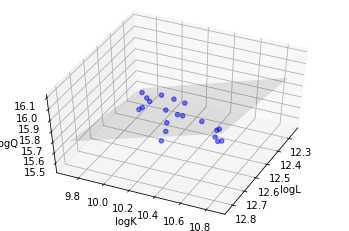

In [10]:
# Plot data and model

# Include standard deviation and confidence interval for prediction
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
#_, upper, lower = wls_prediction_std(model)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x_surf = np.linspace(empl_prod_assets.logL.min(), empl_prod_assets.logL.max(), 2)
y_surf = np.linspace(empl_prod_assets.logK.min(), empl_prod_assets.logK.max(), 2)
x_surf, y_surf = np.meshgrid(x_surf, y_surf)

onlyX = pd.DataFrame({'logL': x_surf.ravel(), 'logK': y_surf.ravel()})
fittedY = model.predict(exog = onlyX)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(empl_prod_assets['logL'],
           empl_prod_assets['logK'],
           empl_prod_assets['logQ'],
           c='blue', marker='o', alpha=0.5)
ax.plot_surface(x_surf,
                y_surf,
                fittedY.values.reshape(x_surf.shape),
                color='None', alpha=0.1, linewidth=1)
ax.set_xlabel('logL')
ax.set_ylabel('logK')
ax.set_zlabel('logQ')

ax.view_init(50, 25)
plt.show()

In [9]:
# Values of regression coefficients
model.params

Intercept    8.195524
logL         0.319914
logK         0.348494
dtype: float64

We therefore get

$$\ln{Q} = 8.195524 + 0.319914\ln{L} + 0.348494\ln{K}$$

$$Q = e^{8.195524}L^{0.319914}K^{0.348494}$$

$$Q = 3625L^{0.319914}K^{0.348494}$$